### 梯度消失与爆炸

目前优化神经网络的方法都是基于反向传播的思想，即根据损失函数计算的误差通过梯度反向传播的方式来指导深度网络权值的更新优化。这样做是有一定原因的，首先，深层网络由许多非线性层堆叠而来，每一层非线性层都可以视为是一个非线性函数 $f(x)$ (非线性来自于非线性激活函数），因此整个深度网络可以视为是一个复合的非线性多元函数 :

$$
F(x)=f_n(...f_3(f_2(f_1(x) * w_1 + b) * w_2 + b)...)
$$

**为什么会出现梯度消失与爆炸？**

假设有三个隐层的单神经元网络：

$$
input Layer \bigcirc -> Hidden Layer1 \bigcirc -> Hidden Layer2 \bigcirc -> Hidden Layer3 \bigcirc -> Outptu Layer \bigcirc
$$

假设每一层网络激活后的输出为$f_i(x)$，其中$i$为第$i$层，$x$代表第$i$层的输入，也是第$i-1$层的输出，$f$是激活函数，可得出$f_{i+1} = f(f_i * w_{i+1} + b_{i+1})$，简记为$f_{i+1} = f(f_i * w_{i+1})$。BP算法基于梯度下降策略，以目标的负梯度方向对参数进行调整，其中的参数更新为$w \gets w + \triangle w$，给定学习率$\alpha$，得出$\triangle w = - \alpha \frac{\partial Loss}{\partial w}$。

若要更新第二隐藏层的权值信息，根据链式求导法则，更新梯度信息为$\triangle w = -\alpha \frac{\partial Loss}{\partial w_2} = -\frac{\partial Loss}{\partial f_4}\frac{\partial f_4}{\partial f_3}\frac{\partial f_3}{\partial f_2}\frac{\partial f_2}{\partial w_2}$，而其中的$\frac{\partial f_4}{\partial f_3} = w_4 f^{'}(f_3w_4)$，$\frac{\partial f_2}{\partial w_2} = f_1f^{'}(f_1w_2)$。如果激活函数求导后与权重相乘的积大于1，那么层数增多的时候，最终求出的梯度更新信息将以指数形式增加，即发生**梯度爆炸**；若此部分小于1，那么随着层数增多，求出的梯度更新信息将以指数形式衰减，即发生**梯度消失**。

**常用解决梯度消失与爆炸的方法**

* 使用 ReLU、LReLU、ELU、maxout 等激活函数；
* 使用批规范化：通过规范化操作将输出信号$x$规范化到均值为0，方差为1来保证网络的稳定性。从上述分析中可以看到，反向传播式子中$w$的大小影响了梯度的消失和爆炸，Batch Normalization 就是通过对每一层的输出规范为均值和方差一致的方法，消除了$w$带来的放大缩小的影响，进而解决梯度消失和爆炸的问题。

### Kaggle房价预测

Kaggle是一个著名的供机器学习爱好者交流的平台。房价预测是其中的一个比赛，其网址为：https://www.kaggle.com/c/house-prices-advanced-regression-techniques 。使用的数据集的下载链接为：https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from IPython import display
from matplotlib import pyplot as plt

test_data = pd.read_csv("D:\\IIE\corpora\\house-prices\\test.csv")
train_data = pd.read_csv("D:\\IIE\\corpora\\house-prices\\train.csv")

print(train_data.shape) #训练数据集包括1460个样本、80个特征和1个标签
print(test_data.shape) #训练数据集包括1459个样本、80个特征

# 查看前4个样本的前4个特征、后2个特征和标签
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

# 预处理

'''
数据集中第一个特征为Id，它虽能帮模型记住每个训练样本，但难以推广到测试样本，所以这里不使用它来训练。
将所有的训练数据和测试数据的79维特征按样本进行连结。
'''

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

# -----------------------数值型特征的处理-------------------------------
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

'''
对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为 𝜇 ，标准差为 𝜎 。
具体将该特征的每个值先减去 𝜇 再除以 𝜎 得到标准化后的每个特征值。
'''
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

# 对于缺失的特征值，我们将其替换成该特征的均值。标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# -----------------------离散型特征的处理-------------------------------
all_features = pd.get_dummies(all_features, dummy_na=True) # dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
print(all_features.shape)

'''
离散值转换为指示特征。例如，特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，
并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。
'''

# 将数据转换为Tensor类型，便于后面使用
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1) #变为列向量

# 定义模型

loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
        
# 在K折交叉验证中训练K次并返回训练和验证的平均误差
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

# 超参数选择

'''
使用一组未经调优的超参数来计算交叉验证误差，通过不断试验可确定最优的超参数。
但要注意：有时会发现一组参数的训练误差可以达到很低，但是在K折交叉验证上的误差可能反而较高。
这种现象可能由过拟合造成的。所以在训练误差降低时，要观察K折交叉验证上的误差是否也相应降低。
'''

k, num_epochs, lr, weight_decay, batch_size = 10, 100, 5, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

# 模型训练和预测

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1]) #获取特征数
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy() #detach()返回相同数据的tensor
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)


### CNN

卷积层：
1.最常见的二维卷积层，常用于处理图像数据。
2.用corr2d函数实现**二维互相关运算**，它接受输入数组X与核数组K，并输出数组Y
3.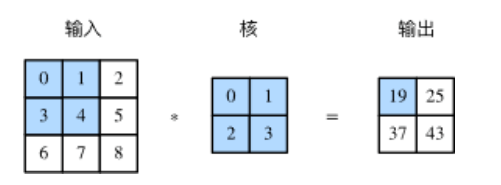

In [1]:
import torch 
import torch.nn as nn

def corr2d(X,K):
    H, W = X.shape
    h, w = K.shape
    Y = torch.zeros(H - h + 1, W - w + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

补充：
shape[0], 图像的垂直尺寸（高度）；
shape[1]：图像的水平尺寸（宽度）
shape[2]：图像的通道数                                   https://blog.csdn.net/xiasli123/article/details/102932607

In [2]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
Y = corr2d(X, K)
print(Y)

tensor([[19., 25.],
        [37., 43.]])


**二维卷积层** 

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏置来得到输出  
    

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight == nn.Paramter(torch.randn(kernel_size))
        self.bias = nn.Paramter(torch.randn(1))
    
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

构造一张的图像，中间4列为黑（0），其余为白（1）

In [4]:
#从0开始算
X = torch.ones(6,8)
Y = torch.zeros(6,7)
X[:,2:6] = 0
Y[:,1] = 1
Y[:,5] = -1
print(X)
print(Y)


tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


**互相运算和卷积运算**

1. 卷积层中用到的并非卷积运算而是互相关运算
2. 卷积计算：将核数组上下翻转、左右翻转，再与输入数组做互相关运算
3. 使用互相关运算与使用卷积运算并无本质区别

**特征图与感受野**
1.  输出---特征图
2.  输入---感受野
3.  可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征


**填充和步幅** --- 可以对给定形状的输入和卷积核改变输出形状
1.  填充padding
       如果原输入的高和宽是和，卷积核的高和宽是和，在高的两侧一共填充行，在宽的两侧一共填充列，则输出形状为：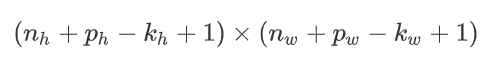
       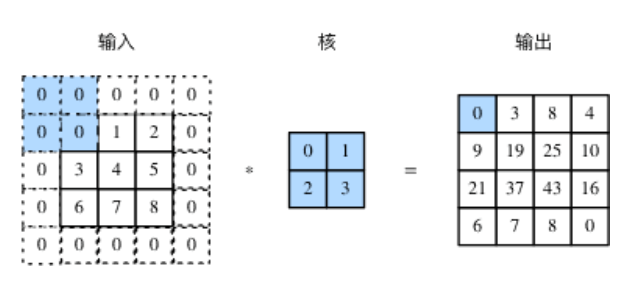
2.  步幅stride!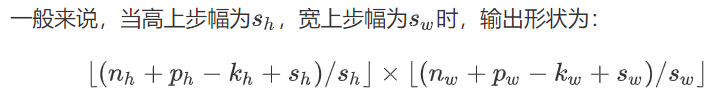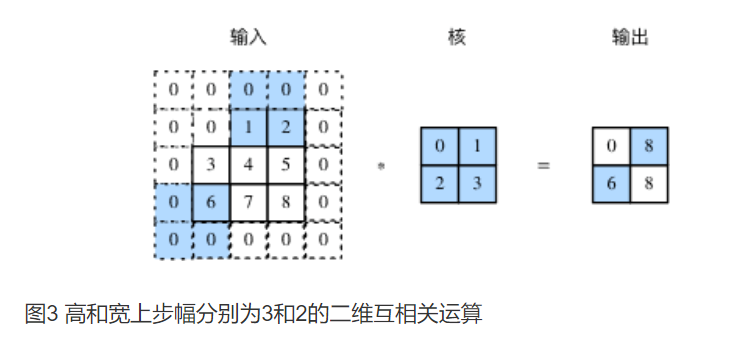
        

**多输入通道**

假设输入数据的通道数为，卷积核形状为，我们为每个输入通道各分配一个形状为的核数组，将个互相关运算的二维输出按通道相加，得到一个二维数组作为输出。我们把个核数组在通道维上连结，即得到一个形状为的卷积核
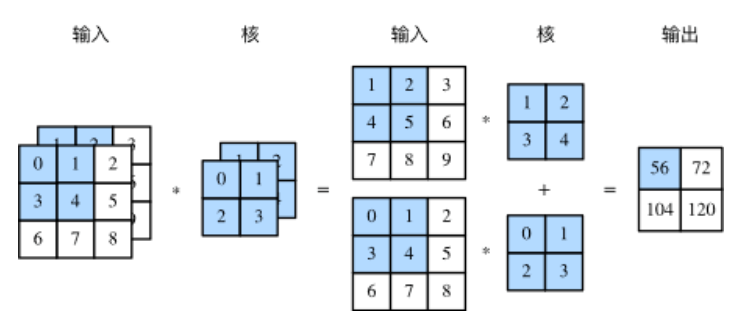


**多输出通道**

对于输出通道的卷积核，我们提供这样一种理解，一个的核数组可以提取某种局部特征，但是输入可能具有相当丰富的特征，我们需要有多个这样的的核数组，不同的核数组提取的是不同的特征。

1.  1x1卷积层

1x1卷积核可在不改变高宽的情况下，调整通道数。1x1卷积核不识别高和宽维度上相邻元素构成的模式，其主要计算发生在通道维上。假设我们将**通道维当作特征维**，将**高和宽维度上的元素当成数据样本**，那么*1x1卷积层的作用与全连接层等价*。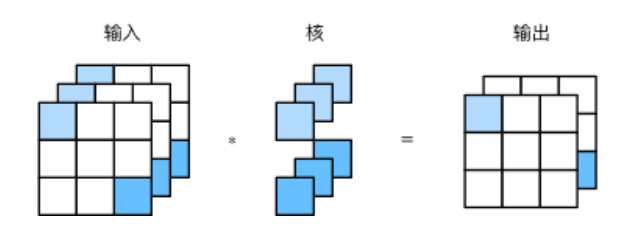


**卷积层与全连接层的对比**
1.  卷积层的设计，天然地具有提取局部信息的能力。全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息
2.  卷积层的参数量更少。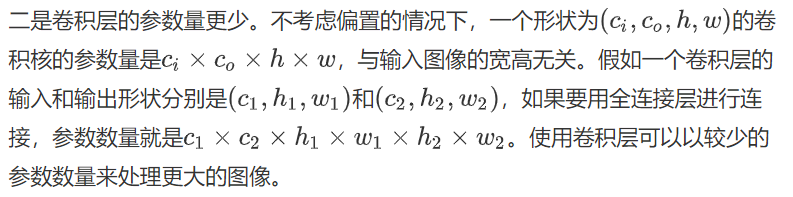

In [6]:
X = torch.rand(4, 2, 3, 5)
print(X.shape)

conv2d = nn.Conv2d(in_channels = 2, out_channels=3, kernel_size=(3,5), stride=1, padding=(1,2))
Y = conv2d(X)
print('Y.shape:', Y.shape)
print('weight.shape:',conv2d.weight.shape)
print('bias.shape:', conv2d.bias.shape)

torch.Size([4, 2, 3, 5])
Y.shape: torch.Size([4, 3, 3, 5])
weight.shape: torch.Size([3, 2, 3, 5])
bias.shape: torch.Size([3])


**池化**

池化层主要用于缓解卷积层对位置的过度敏感性

池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出，池化层直接计算池化窗口内元素的最大值或者平均值，该运算也分别叫做最大池化或平均池化

在处理多通道输入数据时，池化层对每个输入通道分别池化，但不会像卷积层那样将各通道的结果按通道相加。这意味着池化层的输出通道数与输入通道数相等。可以理解为池化层比卷积层少了一个维度（通道维）

In [7]:
X = torch.arange(32, dtype=torch.float32).view(1,2,4,4)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=(2,1))
Y = pool2d(X)
print(X)
print(Y)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]]])
tensor([[[[ 5.,  6.,  7.,  7.],
          [13., 14., 15., 15.]],

         [[21., 22., 23., 23.],
          [29., 30., 31., 31.]]]])
